**Instalación de stability-sdk**


In [ ]:
pip install stability-sdk

**Configurar algunas variables de entorno**

Antes de poder usar el SDK de estabilidad (stability-sdk), debes configurar algunas variables de entorno que se utilizan para autenticar tu cuenta y conectarte al servidor de estabilidad.

El código que mencionaste importa el módulo getpass para solicitar al usuario que introduzca su clave de API, y luego establece dos variables de entorno utilizando el módulo os. STABILITY_HOST es la dirección del servidor de estabilidad, y STABILITY_KEY es la clave de API que identifica a tu cuenta.

Asegúrate de tener tu clave de API lista antes de ejecutar este código. Puedes obtenerla visitando el siguiente enlace: https://beta.dreamstudio.ai/membership

Una vez que hayas establecido estas variables de entorno, deberías poder usar las funciones de predicción de texto e imagen proporcionadas por el SDK de estabilidad.

In [5]:
import getpass, os

# NB: host url is not prepended with \"https\" nor does it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# To get your API key, visit https://beta.dreamstudio.ai/membership
os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

**Este código importa varias bibliotecas y objetos de la biblioteca stability_sdk para configurar y hacer una solicitud al servidor de API de Estabilidad.**

- io: es una biblioteca que proporciona herramientas para manejar entrada/salida de datos.
- os: es una biblioteca que proporciona herramientas para interactuar con el sistema operativo subyacente, como configurar variables de entorno.
-warnings: es una biblioteca que proporciona herramientas para mostrar advertencias en caso de que ocurra algo inesperado.
- IPython.display: es una biblioteca que proporciona herramientas para mostrar contenido en un entorno interactivo de Python, como en Jupyter Notebooks.
- PIL: es una biblioteca que proporciona herramientas para manipular imágenes.
stability_sdk.client: es un módulo de la biblioteca stability_sdk que proporciona una API cliente para interactuar con el servidor de API de Estabilidad.
stability_sdk.interfaces.gooseai.generation.generation_pb2: es un módulo de la biblioteca stability_sdk que define los objetos de protocol buffer utilizados para la generación de texto.
- stability_api: es una instancia de la clase StabilityInference del módulo client, que se utiliza para hacer solicitudes al servidor de API de Estabilidad. En particular, se configura con la clave de API almacenada en la variable de entorno STABILITY_KEY y se habilita el modo de depuración verbose.

In [17]:
import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], 
    verbose=True,
)

**Este código utiliza la biblioteca "stability_sdk" para generar una respuesta de texto a partir de una prompt (un texto que se utiliza como punto de partida) utilizando el modelo de lenguaje de la API de Stability.**

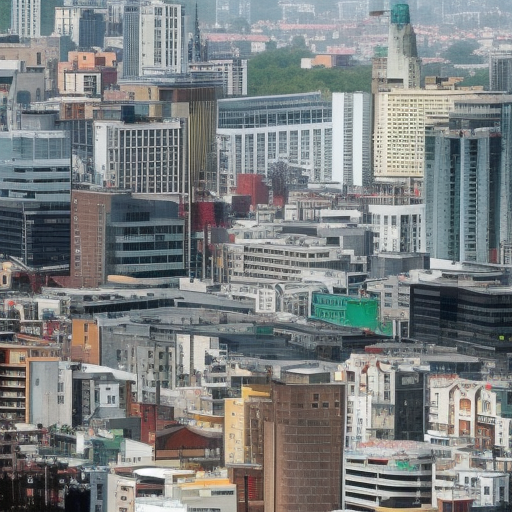

In [27]:
answers = stability_api.generate(
    prompt="A city",
    seed=34567, # Si se proporciona una semilla, los resultados generados serán determinísticos, lo que significa que cada vez que se utilice la misma semilla, se obtendrán los mismos resultados. Esto puede ser útil para fines de depuración y pruebas.
    steps=20, # El parámetro steps especifica la cantidad de pasos o iteraciones que el modelo realizará para generar el texto. Si no se especifica, el valor predeterminado es de 30 pasos
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)

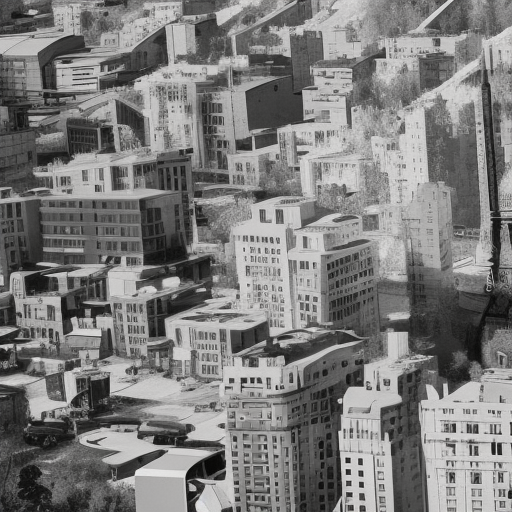

In [28]:
answers = stability_api.generate(
    prompt="childrens crayon drawing a city",
    init_image=img,
    seed=54321, # if we're passing in an image generated by SD, you may get better results by providing a different seed value than was used to generate the image
    start_schedule=0.6, # this controls the "strength" of the prompt relative to the init image
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary))
            display(img2)

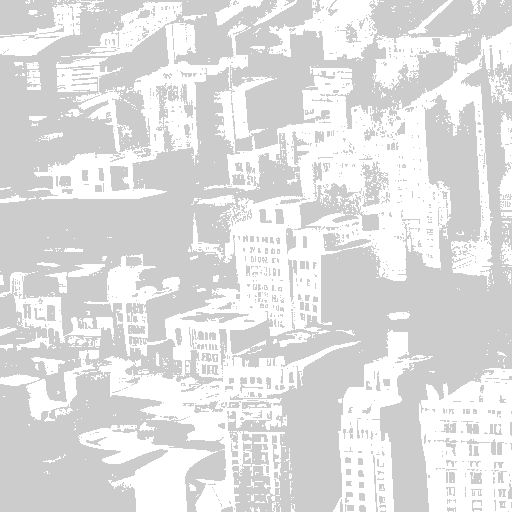

In [29]:
# we can make a rough mask by thresholding the grayscaled image

import numpy as np

img2_grayscale = img2.convert('L')
img2_a = np.array(img2_grayscale)

mask = np.array(img2_grayscale)
mask[img2_a<150] = 0  # this is the area that will get painted, will show up black below
mask[img2_a>=150] = 1 # this is the protected area, will show up white below

strength = .2  # this controls the "strength" of the prompt relative to the init image

d = int(255 * (1-strength))
mask *= 255-d # convert from range [0,1] to [0,255]
mask += d

mask = Image.fromarray(mask)
mask

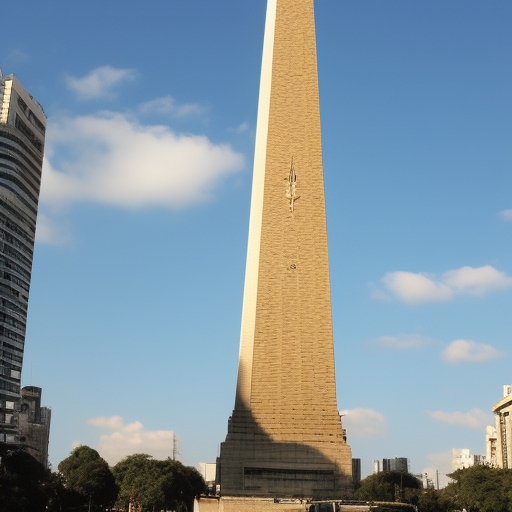

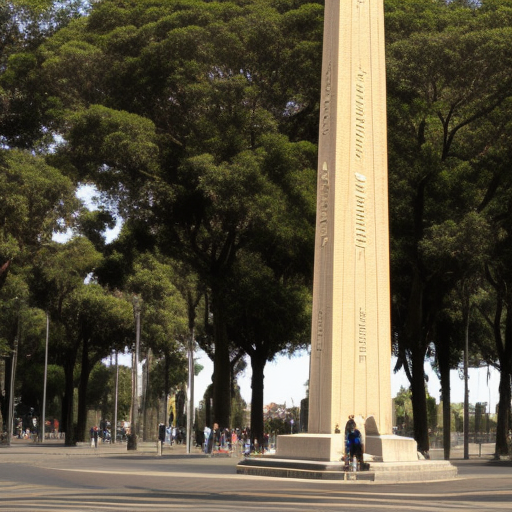

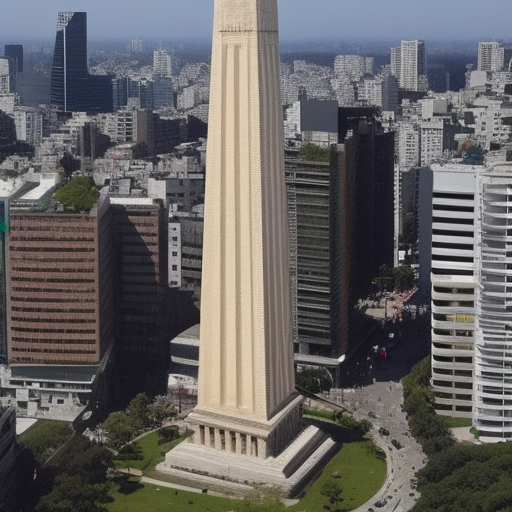

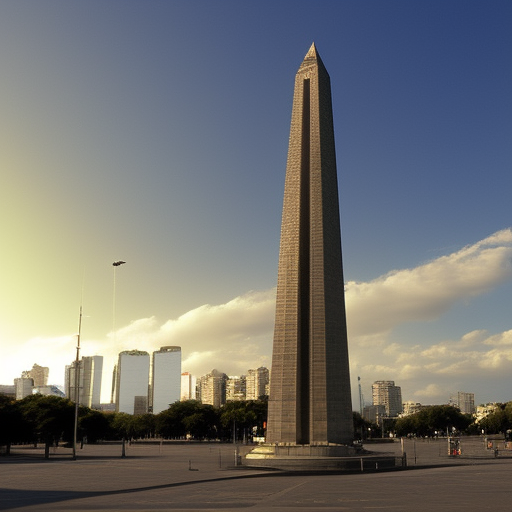

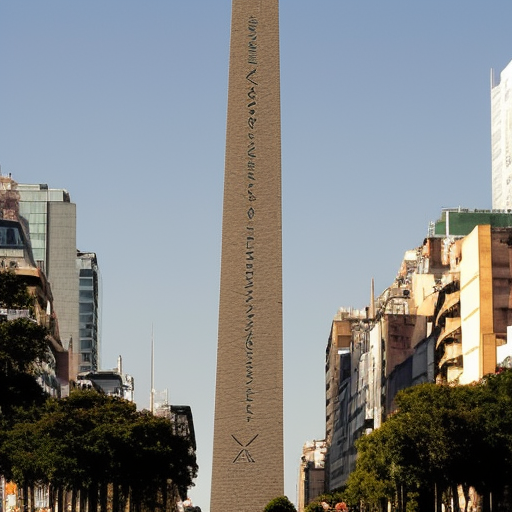

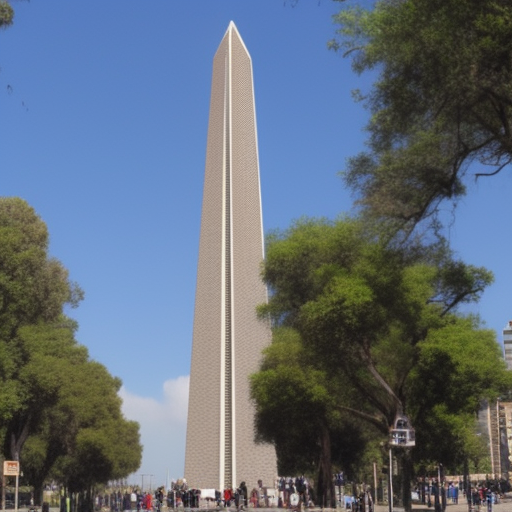

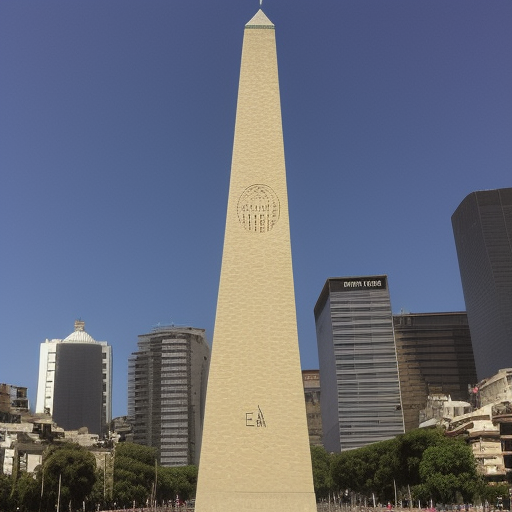

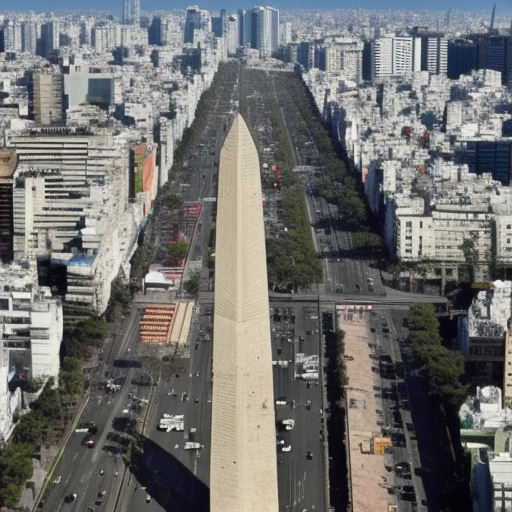

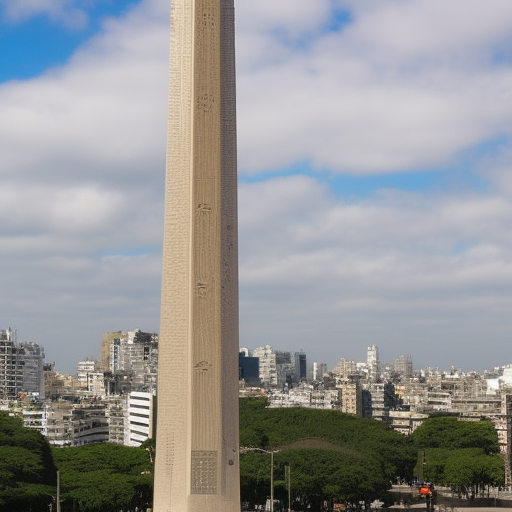

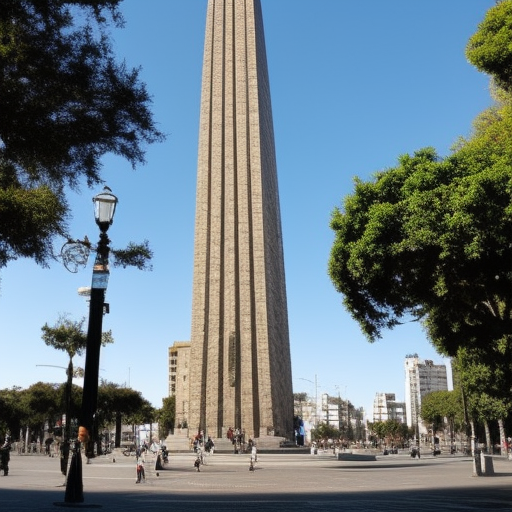

In [53]:
for i in range(10):
    answers = stability_api.generate(
        prompt="EL obelisco de Buenos Aires",
        seed=i, # Cambia la semilla en cada iteración para obtener imágenes diferentes
        steps=20
    )

    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn(
                    "Your request activated the API's safety filters and could not be processed."
                    "Please modify the prompt and try again.")
            if artifact.type == generation.ARTIFACT_IMAGE:
                img = Image.open(io.BytesIO(artifact.binary))
                display(img)
